# Bootstrapping ML Performance

## 0. Env

#### Imports

In [18]:
import os
import numpy as np
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import root_mean_squared_error
import geohash2
import plotly.graph_objects as go
import plotly.express as px
from typing import List, Optional, Literal
import tqdm

In [2]:
pl.Config.set_tbl_rows(20)
pl.Config.set_fmt_str_lengths(90)

polars.config.Config

#### Constants

In [3]:
home = "../.."
images_dir = os.path.join(home, "static/images/")

In [4]:
TRAIN_TEST_SPLIT_FRACTION = .8
MODEL_TARGET = "price_log10"
GEOHASH_PRECISION = 6

In [5]:
MIAMI_MAP_BOUNDS = {
    "west": -80.674245,
    "east": -79.989138,
    "south": 23.003683,
    "north": 27.024563,
}

#### Helper Functions

In [6]:
def plot_geo_df(
    geo_df: pl.DataFrame,
    colorby_column: str,
    colorbar_tickvals: List[int],
    colorbar_ticktext: List[str],
    plot_title: str,
    range_color: Optional[List[int]] = None,
):
    df_sample = geo_df.sample(fraction=1, shuffle=True)
#     range_color = [int(geo_df[colorby_column].min()), int(geo_df[colorby_column].max()) + 1] if not range_color else range_color
    range_color = [geo_df[colorby_column].min(), int(geo_df[colorby_column].max()) + 1] if not range_color else range_color
    fig = px.scatter_mapbox(
        data_frame=df_sample,
        lat="latitude",
        lon="longitude",
        color=colorby_column,
#         range_color=range_color,
        size=[.01] * len(df_sample),
        size_max=2.4
    )
    fig.update_layout(
        mapbox_style="carto-positron",
        margin={"r":0, "t":0, "l":0, "b":0},
        mapbox_bounds=MIAMI_MAP_BOUNDS,
        coloraxis_colorbar={
            "title": plot_title,
            "tickvals": colorbar_tickvals,
            "ticktext": colorbar_ticktext,
        },
    )
    fig.write_image(os.path.join(images_dir, f"miami-{plot_title.lower().replace(' ', '-')}.png"))

## 1. Load Data

In [7]:
# Data taken from https://www.openml.org/search?type=data&id=43093
df = (
    pl.read_csv("../data/miami-housing.csv")
    .with_columns([
        pl.col("SALE_PRC").alias("price"),
        pl.col(["LATITUDE", "LONGITUDE"]).name.to_lowercase()
    ])
    .with_columns([
        pl.col("price").log10().name.suffix("_log10")
    ])
    .with_row_index(name="index")
    .select([
        "index",
        pl.col("index").mod(10).lt(TRAIN_TEST_SPLIT_FRACTION * 10).alias("is_train"),
        "latitude",
        "longitude",
        "price",
        "price_log10"
    ])
)

## 2. Brief EDA

#### Distribution of Prices

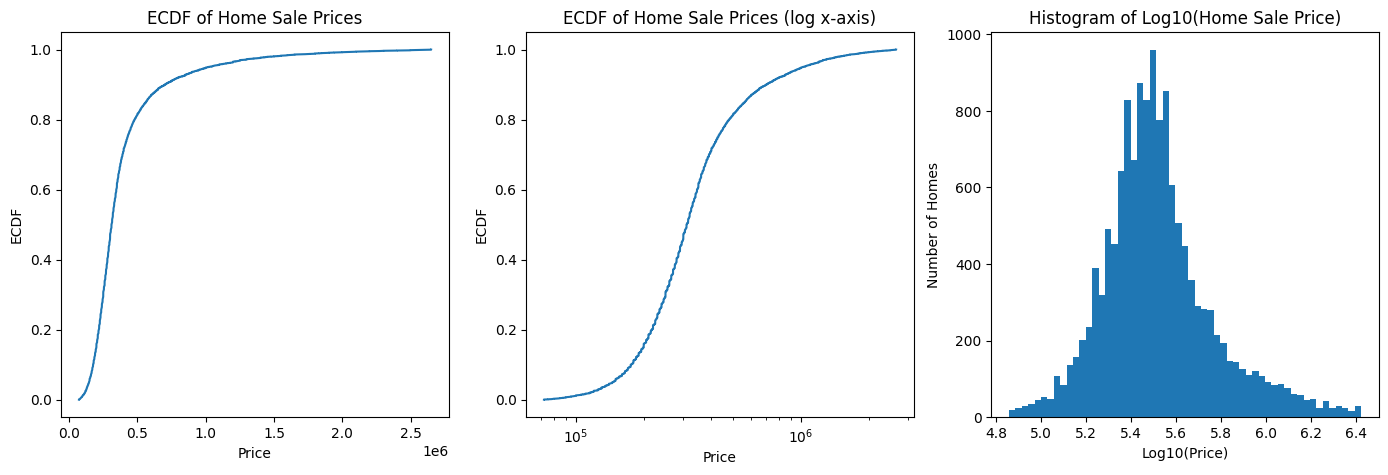

In [8]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(17, 5))

ax1.plot(df["price"].sort(), np.linspace(0, 1, len(df)))
ax1.set_xlabel("Price")
ax1.set_ylabel("ECDF")
ax1.set_title("ECDF of Home Sale Prices")

ax2.plot(df["price"].sort(), np.linspace(0, 1, len(df)))
ax2.set_xscale("log")
ax2.set_xlabel("Price")
ax2.set_ylabel("ECDF")
ax2.set_title("ECDF of Home Sale Prices (log x-axis)")

ax3.hist(df["price_log10"], bins=55, density=False)
ax3.set_xlabel("Log10(Price)")
ax3.set_ylabel("Number of Homes")
ax3.set_title("Histogram of Log10(Home Sale Price)")

plt.savefig(os.path.join(images_dir, "distribution-of-home-sale-price.png"))

#### Distribution over Space

In [9]:
plot_geo_df(
    df,
    colorby_column="price_log10",
    colorbar_tickvals=[1, 2, 3, 4, 5, 6, 7, 8],
    colorbar_ticktext=["$10", "$100", "$1K", "$10K", "$100K", "$1M", "$10M", "$100M"],
    plot_title="Home Sale Price",
)

#### Correlation

In [10]:
df.select(["latitude", "longitude", "price"]).corr()

latitude,longitude,price
f64,f64,f64
1.0,0.721232,0.047701
0.721232,1.0,0.195274
0.047701,0.195274,1.0


## 3. One-Off Results

In [11]:
MODEL_PERFORMANCE_LIST = []

In [12]:
MODEL_FEATURE_LIST_NAME = "raw_lat_lon"
MODEL_FEATURE_LIST = ["latitude", "longitude"]
X_train = df.filter(pl.col("is_train"))
y_train = df.filter(pl.col("is_train"))
X_test = df.filter(~pl.col("is_train"))
y_test = df.filter(~pl.col("is_train"))

for model_name, model_class in zip(
    ["xgboost", "ridge regression"],
    [XGBRegressor, Ridge]
):
    model = model_class().fit(
        X_train.select(MODEL_FEATURE_LIST),
        y_train.select(MODEL_TARGET)
    )
    y_predicted = model.predict(X_test.select(MODEL_FEATURE_LIST))
    model_performance = root_mean_squared_error(y_test.select(MODEL_TARGET), y_predicted)
    model_result = {
        "feature_list_name": MODEL_FEATURE_LIST_NAME,
        "model_name": model_name,
        "model_performance": model_performance
    }
    MODEL_PERFORMANCE_LIST.append(model_result)

### 3.5 Summary

In [13]:
results_feature_set_order = [
    "raw_lat_lon",
#     "spatial_density",
#     "geohash_target_encoding",
#     "all_features"
]

In [14]:
results_summary_df = (
    pd.DataFrame
    .from_records(MODEL_PERFORMANCE_LIST)
    .pivot_table(
        index="feature_list_name",
        columns="model_name",
        values="model_performance",
        aggfunc="first"
    )
)
results_summary_df.columns.name = None
results_summary_df.index.name = None

In [15]:
print(
    results_summary_df
    .loc[results_feature_set_order, :]
    .style
    .format("{:.5f}")
    .background_gradient(vmin=0.1, vmax=0.2, axis=None)
    .to_html()
)

<style type="text/css">
#T_5e1ef_row0_col0 {
  background-color: #023858;
  color: #f1f1f1;
}
#T_5e1ef_row0_col1 {
  background-color: #eee9f3;
  color: #000000;
}
</style>
<table id="T_5e1ef">
  <thead>
    <tr>
      <th class="blank level0" >&nbsp;</th>
      <th id="T_5e1ef_level0_col0" class="col_heading level0 col0" >ridge regression</th>
      <th id="T_5e1ef_level0_col1" class="col_heading level0 col1" >xgboost</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th id="T_5e1ef_level0_row0" class="row_heading level0 row0" >raw_lat_lon</th>
      <td id="T_5e1ef_row0_col0" class="data row0 col0" >0.24179</td>
      <td id="T_5e1ef_row0_col1" class="data row0 col1" >0.11113</td>
    </tr>
  </tbody>
</table>



## 4. Bootstrap results

#### bootstrap experiment function

In [16]:
def execute_bootstrap_experiment_run(
    experiment_df: pl.DataFrame,
    model_features: List[str],
    model_target: str,
    experiment_model_classes: List[Literal[XGBRegressor, Ridge]],
    experiment_model_names: List[Literal["xgboost", "ridge_regression"]],
) -> float:
    bootstrapped_train_df = (
        experiment_df
        .sample(
            fraction=1,
            with_replacement=True,
            shuffle=True
        )
    )
    bootstrapped_test_df = (
        experiment_df
        .join(
            bootstrapped_train_df.unique(subset=["index"]),
            on="index",
            how="anti"
        )
        .sample(
            fraction=1,
            with_replacement=True
        )
    )
    X_train = bootstrapped_train_df.select(model_features)
    y_train = bootstrapped_train_df[model_target]
    X_test = bootstrapped_test_df.select(model_features)
    y_test = bootstrapped_test_df[model_target]
    model_results_dict = {}
    for model_name, model_class in zip(
        experiment_model_names,
        experiment_model_classes
    ):
        model = model_class().fit(
            X_train.select(model_features),
            y_train
        )
        y_predicted = model.predict(X_test.select(model_features))
        model_performance = root_mean_squared_error(y_test, y_predicted)
        model_results_dict[model_name] = model_performance
    return model_results_dict

#### collect results

In [29]:
experiment_run_results = [
    execute_bootstrap_experiment_run(
        experiment_df=df,
        model_features=MODEL_FEATURE_LIST,
        model_target=MODEL_TARGET,
        experiment_model_classes=[XGBRegressor, Ridge],
        experiment_model_names=["xgboost", "ridge_regression"],
    )
    for _ in tqdm.tqdm(range(1000))
]

100%|███████████████████████████████████████| 1000/1000 [06:41<00:00,  2.49it/s]


In [30]:
# bootstrap_exp_result_dict = {
#     "xgboost_rmse_list": xgboost_results,
#     "ridge_regression_rmse_list": ridge_regression_results,
# }
bootstrap_exp_result_dict = {
    f"{k}_rmse_list": [dic[k] for dic in experiment_run_results]
    for k in experiment_run_results[0]
}
bootstrap_exp_result_dict["xgboost_rmse_abs_diff_ridge_regression_list"] = [
    dic["xgboost"] - dic["ridge_regression"]
    for dic in experiment_run_results
]

#### plot results

In [31]:
def get_ecdf_cis(ecdf_x, ci_widths=[.75, .95]):
    ecdf_y = np.linspace(0, 1, len(ecdf_x))
    ci_pctile_pairs = [
        [(1 - ci_width) / 2, 1 - ((1 - ci_width) / 2)]
        for ci_width in ci_widths
    ]
    ci_x_loc_pairs = [
        [ecdf_x[np.argmin(np.abs(ecdf_y - bound))] for bound in ci_bound_pair]
        for ci_bound_pair in ci_pctile_pairs
    ]
    return ci_x_loc_pairs

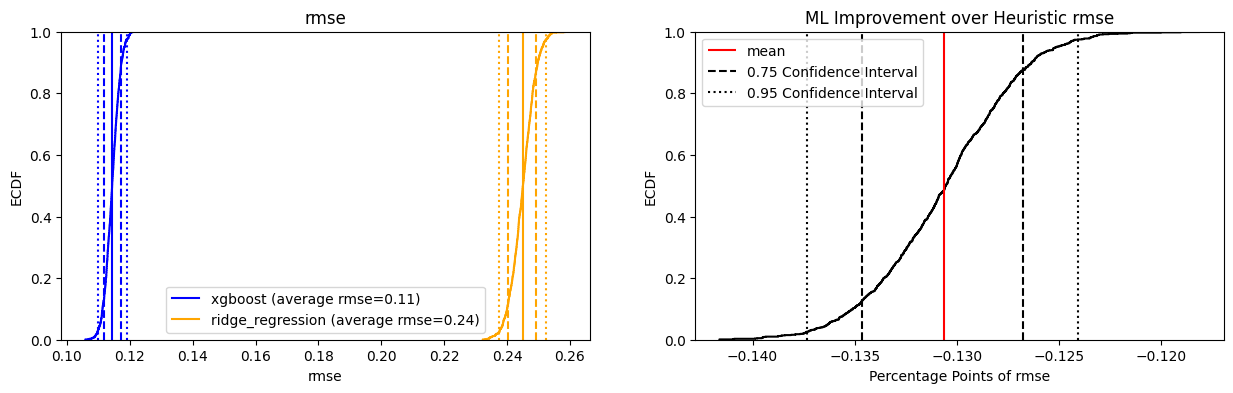

In [32]:
ci_widths = [.75, .95]
ci_linestyles = ["dashed", "dotted"]

# subplots
fig, ax = plt.subplots(1, 2, figsize=(15, 4))

# compare rmses side by side
for approach, color in zip(["xgboost", "ridge_regression"], ["blue", "orange"]):
    data = sorted(bootstrap_exp_result_dict[f"{approach}_rmse_list"])
    ci_x_loc_pairs = get_ecdf_cis(data, ci_widths=ci_widths)
    ax[0].ecdf(data, label=f"{approach} (average rmse={np.mean(data):.2f})", color=color)
    ax[0].vlines(np.mean(data), ymin=0, ymax=1, color=color)#, label="mean")
    ci_x_loc_pairs = get_ecdf_cis(data, ci_widths=ci_widths)
    for ci_width, ci_x_loc_pair, linestyle in zip(ci_widths, ci_x_loc_pairs, ci_linestyles):
        ax[0].vlines(
            x=ci_x_loc_pair,
            ymin=0,
            ymax=1,
            color=color,
            linestyles=linestyle,
        )
ax[0].legend()
ax[0].set_title("rmse")
ax[0].set_xlabel("rmse")
# ax[0].set_xlim(0, 1)
ax[0].set_ylabel("ECDF")

# ecdf of percent improvements
# ecdf_x = sorted([100 * i for i in bootstrap_exp_result_dict[f"model_rmse_pct_diff_heuristic_list"]])
ecdf_x = sorted(bootstrap_exp_result_dict[f"xgboost_rmse_abs_diff_ridge_regression_list"])
ax[1].ecdf(ecdf_x, color="black")
ax[1].set_title(f"ML Improvement over Heuristic rmse")
ax[1].set_xlabel(f"Percentage Points of rmse")
ax[1].set_ylabel("ECDF")

# plot vlines of CIs
ax[1].vlines(np.mean(ecdf_x), ymin=0, ymax=1, color="red", label="mean")
ci_linestyles = ["dashed", "dotted"]
ci_x_loc_pairs = get_ecdf_cis(ecdf_x, ci_widths=ci_widths)
for ci_width, ci_x_loc_pair, linestyle in zip(ci_widths, ci_x_loc_pairs, ci_linestyles):
    ax[1].vlines(
        x=ci_x_loc_pair,
        ymin=0,
        ymax=1,
        color="black",
        linestyles=linestyle,
        label=f"{ci_width} Confidence Interval"
    )
ax[1].legend()

plt.show()